In [1]:

import pandas as pd
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
import random
import json
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cosine
from sklearn.metrics import pairwise_distances
from scipy.sparse import coo_matrix
from sklearn.decomposition import LatentDirichletAllocation
import lda

pd.set_option('display.max_columns', 500)
%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# Data Gathering and Preparation

## Data prepocessing and Data integrity checks

In [2]:
# Read data
df = pd.read_csv("music.tsv",delimiter='\t',encoding='utf-8',header=None)
# Rename the columns
df.columns = ['userID','playerID','playerName','playNum']
# Remove the missing values
df.dropna(inplace=True)
# Data cleaning and turned the complicated ID format to the simple one.
_, user_id = np.unique(df.userID, return_inverse=True)
_, player_id = np.unique(df.playerID, return_inverse=True)
df['userID'] = user_id
df['playerID'] = player_id
df['userID'] = df['userID'].astype(np.int32)
df['playerID'] = df['playerID'].astype(np.int32)
df['playNum'] = df['playNum'].astype(np.int32)

s_player = df[['playerID', 'playerName']].drop_duplicates(subset='playerID').set_index('playerID').sort_index()
df.drop('playerName', axis=1, inplace=True)
df.head()

,userID,playerID,playNum
0,0,37425,2137
1,0,152038,1099
2,0,112364,897
3,0,38434,717
4,0,117441,706


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17309316 entries, 0 to 17535654
Data columns (total 3 columns):
userID      int32
playerID    int32
playNum     int32
dtypes: int32(3)
memory usage: 330.1 MB


In [4]:
print(df.userID.max())
print(df.playerID.max())
print(df.playNum.max())
print(df.userID.min())
print(df.playerID.min())
print(df.playNum.min())

358857
160110
419157
0
0
1


## Using SQL

In [344]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///:memory:')
import sqlite3

In [345]:
df.to_sql('data',engine)

In [346]:
# connecting to the database 
connection = sqlite3.connect("data.db")

In [347]:
pd.read_sql_query('SELECT COUNT(*) FROM data GROUP BY userID', engine)

,COUNT(*)
0,49
1,51
2,46
3,48
4,49
5,50
6,49
7,55
8,48
9,57


In [348]:
pd.read_sql_query('SELECT playerID,COUNT(*) AS number FROM data GROUP BY playerID ORDER BY number DESC', engine)

,playerID,number
0,104608,77254
1,110770,76271
2,127797,66658
3,87685,48930
4,97938,46954
5,63907,45233
6,82630,44444
7,93784,41229
8,153687,39778
9,127760,37271


## Feature Engineering

In [5]:
# pivot the matrix using sparse matrix. A low is a user, and each columns is the artist he listened, the values are the play times.
user_item_sp_mat = coo_matrix((df.playNum, (df.userID, df.playerID)), (df.userID.max()+1, df.playerID.max()+1), dtype=np.int32)

In [60]:
user_item_sp_mat

<358858x160111 sparse matrix of type '<class 'numpy.int32'>'
	with 17309316 stored elements in COOrdinate format>

# Model (LDA)

#### This is a unsupervised Problem. We used Latent Dirichlet allocation(LDA) to do the dimensions reduction which is clustering. We divided 160k artists into 20 class, according to the taste of users which is the latent variable.


In [ ]:
# Run LDA model
lda = LatentDirichletAllocation(n_components=20, max_iter=10, random_state=0)
lda.fit(user_item_sp_mat)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [293]:
lda.transform(user_item_sp_mat)

array([[1.18521996e-02, 3.14321198e-01, 2.30725647e-01, ...,
        2.98017515e-02, 1.22660813e-02, 2.99096728e-06],
       [4.37706330e-02, 4.16937677e-07, 4.16937676e-07, ...,
        4.16937677e-07, 1.88498698e-01, 7.73175606e-02],
       [3.59918720e-01, 8.66400970e-06, 8.66400970e-06, ...,
        8.66400979e-06, 4.32492087e-02, 5.84304083e-01],
       ...,
       [9.24385285e-06, 4.30781116e-02, 5.99731800e-02, ...,
        1.04622041e-01, 4.14335390e-01, 3.14396062e-02],
       [6.71952695e-06, 6.71952696e-06, 4.30781335e-01, ...,
        1.66631953e-02, 6.71952695e-06, 6.71952695e-06],
       [8.48303239e-03, 8.71115999e-03, 3.36927224e-05, ...,
        3.36927225e-05, 1.91746895e-02, 3.36927231e-05]])

## Check the comparable number of points in each cluster.

In [104]:
for i in range(0,20):
    print(lda.components_[[i]].size)

160111
160111
160111
160111
160111
160111
160111
160111
160111
160111
160111
160111
160111
160111
160111
160111
160111
160111
160111
160111


In [119]:
# Check the covariance. In each cluster, inoder to check, we over it with 100000000
for i in range(0,19):
    print(np.cov(lda.components_[[i]])/100000000)

9.985488059739923
9.237519103879476
13.94716914225564
24.188243784157514
77.32077605494896
3.872186868157884
13.20738904576523
30.639151373011092
6.211481279179348
3.35539908088835
19.632366139391845
35.939598047667516
50.592676166473446
10.871454803867735
27.260207464677848
7.08892510033816
2.0340641561144874
46.088457479196805
2.9897377197721373


#### we can see that each cluster contains the same point number and in each cluster, the points are hight corrected with each other.

## Interpretations for the clusters 

In [21]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [122]:
print_top_words(lda, s_player.playerName, 5)

Topic #0: tom waits, sonic youth, animal collective, pixies, the magnetic fields
Topic #1: nofx, bad religion, misfits, ramones, dropkick murphys
Topic #2: nightwish, sonata arctica, blind guardian, kamelot, apocalyptica
Topic #3: blink-182, fall out boy, my chemical romance, paramore, rise against
Topic #4: the beatles, bob dylan, the rolling stones, johnny cash, u2
Topic #5: miles davis, frank sinatra, johann sebastian bach, norah jones, amy winehouse
Topic #6: opeth, in flames, slayer, katatonia, amon amarth
Topic #7: pink floyd, metallica, iron maiden, ac/dc, queen
Topic #8: tori amos, enya, hans zimmer, enigma, yann tiersen
Topic #9: dir en grey, as i lay dying, bring me the horizon, larc~en~ciel, parkway drive
Topic #10: red hot chili peppers, tool, queens of the stone age, foo fighters, incubus
Topic #11: system of a down, linkin park, rammstein, in flames, koЯn
Topic #12: radiohead, death cab for cutie, arctic monkeys, bloc party, sufjan stevens
Topic #13: kanye west, lil wayne

#### We have 20 classes of artists now. We choose some classes to check the style of those artists. Topic 0 seems like Rock. Topic 1 is punk rock. We can conclude that if a user likes an artist in topic0, he also may like others artists in the same topic.

## Investigate properties of those clusters

In [123]:
from sklearn.externals import joblib
joblib.dump(lda, 'lda.pkl')

['lda.pkl']

In [127]:
lda.components_.shape

(20, 160111)

In [30]:
user_components = lda.transform(user_item_sp_mat)
user_components.shape

(358858, 20)

#### We reduced the dimensions of the original user-artist matrix into two matrixs. One is use 20 classes to represent users, according to the artists, the other one use 20 classes to represent artists, according to the users.

### The process to use the model. Input is a artist's name and output is the artist(s) in the same style.

In [240]:
def getName(name):
    for i in range(s_player.shape[0]):
        if s_player.iloc[i].playerName == name:
            topic=lda.components_[:, i].argmax()
            for j in range(0,9):
                artists = lda.components_[[topic]].argsort(axis=1)
                if s_player.iloc[artists[0][-j]].playerName == name:
                    continue;
                else:
                    print(s_player.iloc[artists[0][-j]].playerName)

In [241]:
getName('bad religion')

back 2 bass
nofx
misfits
ramones
dropkick murphys
rancid
against me!
the clash


In [ ]:
name = input("Enter the name of artist")
print("The artists that you would like")
getName(name)

## clusters stable

In [412]:
sample = df.iloc[0:100000]

In [271]:
# pivot the matrix using sparse matrix. A low is a user, and each columns is the artist he listened, the values are the play times.
user_item_sp_mat_1 = coo_matrix((sample.playNum, (sample.userID, sample.playerID)), (sample.userID.max()+1, sample.playerID.max()+1), dtype=np.int32)

In [413]:
# Run LDA model time1
lda_11 = LatentDirichletAllocation(n_components=10, max_iter=10)
lda_11.fit(user_item_sp_mat_1)
lda_11.transform(user_item_sp_mat_1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


array([[5.98212962e-06, 2.19097686e-01, 5.98281759e-06, ...,
        6.61179730e-03, 5.98282267e-06, 5.98224285e-06],
       [8.33879024e-07, 8.33888603e-07, 8.33879979e-07, ...,
        8.33940743e-07, 8.48152946e-01, 8.33886307e-07],
       [1.73281645e-05, 1.73281037e-05, 7.82272945e-02, ...,
        1.73280274e-05, 1.40636255e-01, 7.81015147e-01],
       ...,
       [4.98020001e-05, 4.98098701e-05, 4.98012597e-05, ...,
        4.98127404e-05, 4.98080141e-05, 4.98020930e-05],
       [1.53587156e-05, 1.53588587e-05, 1.53586702e-05, ...,
        1.53595691e-05, 1.53590064e-05, 9.55279062e-01],
       [4.01929260e-05, 4.01929260e-05, 4.01929260e-05, ...,
        3.84158375e-01, 4.01929260e-05, 4.01929261e-05]])

In [414]:
# Run LDA model time1
lda_12 = LatentDirichletAllocation(n_components=30, max_iter=10)
lda_12.fit(user_item_sp_mat_1)
lda_12.transform(user_item_sp_mat_1)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


array([[1.99397819e-06, 1.99397819e-06, 1.99397819e-06, ...,
        1.99397819e-06, 1.99397819e-06, 1.99397819e-06],
       [2.77958451e-07, 2.77958451e-07, 2.77958451e-07, ...,
        2.77958451e-07, 2.77958451e-07, 2.77958451e-07],
       [5.77600647e-06, 5.77600647e-06, 1.59182628e-02, ...,
        5.77600647e-06, 5.77600647e-06, 5.77600647e-06],
       ...,
       [1.66002656e-05, 1.66002656e-05, 1.51846428e-01, ...,
        1.66002656e-05, 1.66002656e-05, 1.66002656e-05],
       [2.41738448e-01, 5.11954129e-06, 1.05615463e-01, ...,
        1.11406879e-01, 5.11954129e-06, 5.11954129e-06],
       [1.33976420e-05, 1.33976420e-05, 1.33976420e-05, ...,
        1.33976420e-05, 1.33976420e-05, 1.33976420e-05]])

In [416]:
# Run LDA model time1
lda_13 = LatentDirichletAllocation(n_components=40, max_iter=10)
lda_13.fit(user_item_sp_mat_1)
lda_13.transform(user_item_sp_mat_1)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


array([[1.49548364e-06, 1.49548364e-06, 1.49548364e-06, ...,
        1.49548364e-06, 7.09681668e-02, 1.49548364e-06],
       [2.08468838e-07, 2.08468838e-07, 2.08468838e-07, ...,
        2.08468838e-07, 2.08468838e-07, 2.08468838e-07],
       [4.33200485e-06, 4.33200485e-06, 4.33200485e-06, ...,
        4.33200485e-06, 4.33200485e-06, 4.33200485e-06],
       ...,
       [1.95196580e-02, 1.24501992e-05, 1.24501992e-05, ...,
        1.24501992e-05, 1.24501992e-05, 1.24501992e-05],
       [3.83965597e-06, 3.83965597e-06, 3.83965597e-06, ...,
        3.83965597e-06, 3.83965597e-06, 3.83965597e-06],
       [1.00482315e-05, 1.00482315e-05, 1.00482315e-05, ...,
        1.00482315e-05, 1.00482315e-05, 1.00482315e-05]])

In [438]:
y11= np.sum(sum(np.cov(lda_11.transform(user_item_sp_mat_1))))

In [439]:
y12=np.sum(sum(np.cov(lda_2.transform(user_item_sp_mat_1))))

In [440]:
y13=np.sum(sum(np.cov(lda_12.transform(user_item_sp_mat_1))))

In [443]:
y14=np.sum(sum(np.cov(lda_13.transform(user_item_sp_mat_1))))

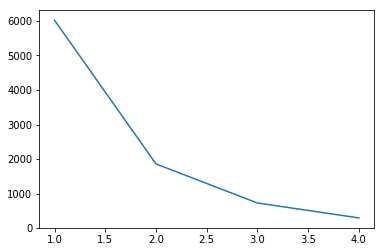

In [445]:
y1_sample = [y11,y12,y13,y14]
x1_sample = [1,2,3,4]
plt.plot(x1_sample,y1_sample)
plt.show()

In [290]:
# Run LDA model time1
lda_2 = LatentDirichletAllocation(n_components=20, max_iter=10)
lda_2.fit(user_item_sp_mat_1)
lda_2.transform(user_item_sp_mat_1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topic #0: bad religion, nofx, misfits, rancid, the clash
Topic #1: coldplay, john mayer, moby, keane, hans zimmer
Topic #2: metallica, koЯn, system of a down, die Ärzte, ac/dc
Topic #3: muse, red hot chili peppers, system of a down, pink floyd, nirvana
Topic #4: nine inch nails, queens of the stone age, radiohead, the cure, depeche mode
Topic #5: radiohead, sigur rós, bright eyes, boards of canada, broken social scene
Topic #6: the beatles, jack johnson, led zeppelin, oasis, the rolling stones
Topic #7: Последние Танки в Париже, sonata arctica, bob marley, within temptation, nightwish
Topic #8: garbage, the cardigans, lady gaga, metric, thomas dybdahl
Topic #9: lil wayne, daft punk, new order, radiohead, ryan adams
Topic #10: iron maiden, slayer, café tacuba, opeth, megadeth
Topic #11: bob dylan, tom waits, elliott smith, ray lamontagne, johnny cash
Topic #12: kanye west, atb, 50 cent, jay-z, the game
Topic #13: diary of dreams, clock dva, apoptygma berzerk, skinny puppy, kmfdm
Topic #

In [377]:
# Run LDA model time2
lda_1 = LatentDirichletAllocation(n_components=20, max_iter=10)
lda_1.fit(user_item_sp_mat_1)
lda_1.transform(user_item_sp_mat_1)

In [378]:
# Run LDA model time3
lda_3 = LatentDirichletAllocation(n_components=20, max_iter=10)
lda_3.fit(user_item_sp_mat_1)
lda_3.transform(user_item_sp_mat_1)
print_top_words(lda_3, s_player.playerName, 5)

In [358]:
# Run LDA model time4
lda_4 = LatentDirichletAllocation(n_components=20, max_iter=10)
lda_4.fit(user_item_sp_mat_1)
lda_4.transform(user_item_sp_mat_1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


array([[2.99096730e-06, 2.99096730e-06, 2.99096730e-06, ...,
        2.42164785e-01, 2.99096729e-06, 2.99096728e-06],
       [4.16937677e-07, 4.16937676e-07, 4.16937676e-07, ...,
        4.16937676e-07, 4.16937679e-07, 4.16937676e-07],
       [8.66400971e-06, 8.66400972e-06, 8.66400977e-06, ...,
        8.66400970e-06, 8.66400971e-06, 8.66400971e-06],
       ...,
       [6.22978994e-03, 2.49003984e-05, 1.54720417e-01, ...,
        2.49003985e-05, 2.49003987e-05, 2.49003984e-05],
       [7.67931194e-06, 1.05569921e-01, 7.92559319e-02, ...,
        7.67931194e-06, 7.67931194e-06, 7.67931194e-06],
       [2.00964630e-05, 2.00964630e-05, 2.00964630e-05, ...,
        2.00964630e-05, 2.00964630e-05, 2.00964630e-05]])

In [362]:
# Run LDA model time5
lda_5 = LatentDirichletAllocation(n_components=20, max_iter=10)
lda_5.fit(user_item_sp_mat_1)
lda_5.transform(user_item_sp_mat_1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


array([[2.99096728e-06, 7.73252303e-01, 2.99096733e-06, ...,
        2.39617808e-02, 2.99096728e-06, 2.99096732e-06],
       [9.99992078e-01, 4.16937676e-07, 4.16937676e-07, ...,
        4.16937678e-07, 4.16937676e-07, 4.16937676e-07],
       [8.66400970e-06, 8.66400974e-06, 8.66400970e-06, ...,
        8.66400971e-06, 8.66400970e-06, 1.24798128e-01],
       ...,
       [2.49003985e-05, 5.63422491e-02, 2.49003986e-05, ...,
        2.49003987e-05, 2.49003984e-05, 1.07134775e-01],
       [7.67931195e-06, 6.77043316e-02, 7.67931194e-06, ...,
        7.67931199e-06, 7.67931194e-06, 7.62042322e-01],
       [2.00964630e-05, 2.00964630e-05, 2.00964630e-05, ...,
        2.00964630e-05, 2.00964630e-05, 6.07668875e-01]])

In [420]:
y1 = np.sum(sum(np.cov(lda_5.transform(user_item_sp_mat_1),lda_3.transform(user_item_sp_mat_1))))

In [421]:
y2 = np.sum(sum(np.cov(lda_5.transform(user_item_sp_mat_1),lda_2.transform(user_item_sp_mat_1))))

In [422]:
y3 = np.sum(sum(np.cov(lda_5.transform(user_item_sp_mat_1),lda_1.transform(user_item_sp_mat_1))))

In [423]:
y5 = np.sum(sum(np.cov(lda_2.transform(user_item_sp_mat_1),lda_1.transform(user_item_sp_mat_1))))

In [424]:
y6 = np.sum(sum(np.cov(lda_3.transform(user_item_sp_mat_1),lda_1.transform(user_item_sp_mat_1))))

In [425]:
y7 = np.sum(sum(np.cov(lda_3.transform(user_item_sp_mat_1),lda_2.transform(user_item_sp_mat_1))))

In [426]:
y8 = np.sum(sum(np.cov(lda_4.transform(user_item_sp_mat_1),lda_2.transform(user_item_sp_mat_1))))

In [427]:
y = [y1,y2,y3,y5,y6,y7,y8]

In [428]:
x = [1,2,3,4,5,6,7]

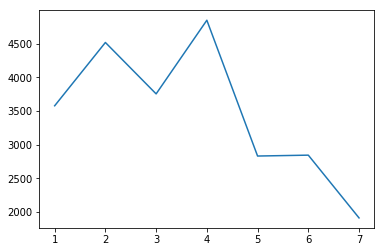

In [429]:
plt.plot(x,y)
plt.show()

## Extra interesting ideas(using neutral network to do the non-linear dimensions reduction)

### Input user features on artist into a neural network and get a output with n dimensions which is latent features represent the style of the user. Do the same thing to artist and get a output represent the style of artist. The inner product of these latent  features is the play times. This is the process similar to LDA, but is non-linear. We hope this kind of non-linear model could explore more deep relationship between users and artists.